<h2 align="center"> <font color='violet'>Optimal Transport with marginals</font></h2>

In [26]:
import equinox as eqx
import jax
import jax.numpy as jnp
import equinox.nn as nn

class Test(eqx.Module):
    mlp: eqx.Module
    
    def __init__(self, key):
        self.mlp = nn.MLP(2, 2, 2, 2, key=key)
        
    def __call__(self, x, y, z):
        s1 = self.mlp(x)
        s2 = self.mlp(y)
        s3 = self.mlp(z)
        return jax.numpy.multiply(s1, s2) * s3
    
keys = jax.random.split(jax.random.PRNGKey(42), 2)

@eqx.filter_vmap
def ensemblize(keys):
    return Test(keys)

ensemble = ensemblize(keys)

In [27]:
x = jax.random.normal(key=keys[2], shape=(10, 2))
y = jax.random.normal(key=keys[0], shape=(10, 2))
z = jax.random.normal(key=keys[1], shape=(10, 2))

In [28]:
@eqx.filter_vmap(in_axes=dict(model=eqx.if_array(0), x=None, y=None, z=None))
def evaluate_ensemble(model, x, y, z):
    return jax.vmap(model)(x,y,z)
evaluate_ensemble(ensemble,x ,y,z)

Array([[[-8.8754305e-08, -1.6000947e-01],
        [-7.5113006e-05, -1.4488317e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-2.3377052e-06, -1.5301797e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-8.8754305e-08, -1.6000947e-01],
        [-2.6882940e-04, -1.3157992e-01]],

       [[ 1.0471903e-01, -1.6631925e-02],
        [ 7.6325975e-02, -1.1437074e-03],
        [ 5.6510419e-02, -1.4339470e-05],
        [ 8.2739942e-02, -2.5751864e-04],
        [ 9.6867792e-02, -5.2248640e-03],
        [ 1.2098087e-01, -4.9242605e-03],
        [ 1.2619162e-01, -6.6512823e-03],
        [ 1.2494019e-01, -1.2110239e-02],
        [ 8.1857964e-02, -2.4900120e-04],
        [ 9.8819651e-02, -2.2044883e-03]]], dtype=float32)

In [29]:
q1, q2 = evaluate_ensemble(ensemble,x ,y,z)

In [7]:
x = jax.random.normal(key=keys[2], shape=(10, 2))

@eqx.filter_vmap(in_axes=(eqx.if_array(0), 0))
def eval(ens, x):
    return ens(x)
eval(ensemble, x)

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (6 of them) had size 2, e.g. axis 0 of argument _dynamic_args[0].layers[0].weight of type float32[2,2,2];
  * one axis had size 10: axis 0 of argument _dynamic_args[1] of type float32[10,2]

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import ott
from ott.solvers.linear import sinkhorn
from ott.geometry import pointcloud

import matplotlib.pyplot as plt
import pprint


In [4]:
rngs = jax.random.PRNGKey(42)
key1, key2 = jax.random.split(rngs, 2)
x = jax.random.normal(key1, (4, 2))
y =  jax.random.normal(key2, (5, 2))

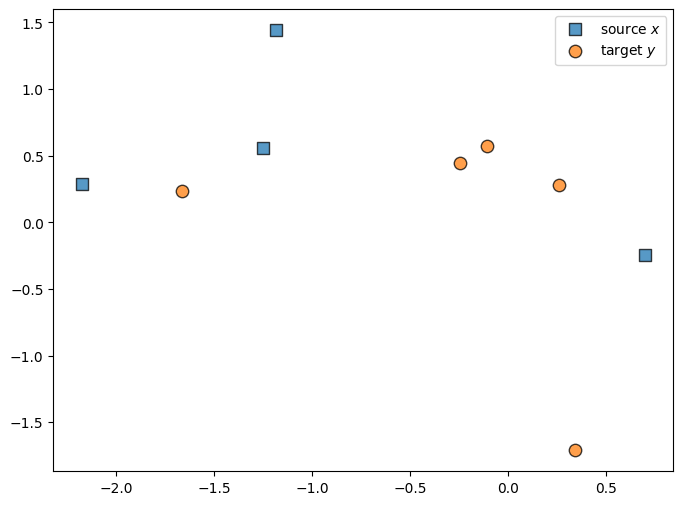

In [5]:
x_args = {
    "s": 80,
    "label": r"source $x$",
    "marker": "s",
    "edgecolor": "k",
    "alpha": 0.75,
}
y_args = {"s": 80, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}

fig = plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], **x_args)
plt.scatter(y[:, 0], y[:, 1], **y_args)
plt.legend()
fig.show()

In [12]:
def compute_ot(x, y):
    geom = pointcloud.PointCloud(x, y, epsilon=1)
    prob = ott.problems.linear.linear_problem.LinearProblem(geom)
    ot = jax.jit(sinkhorn.Sinkhorn())(prob)
    return ot

In [13]:
ot_map = compute_ot(x, y)

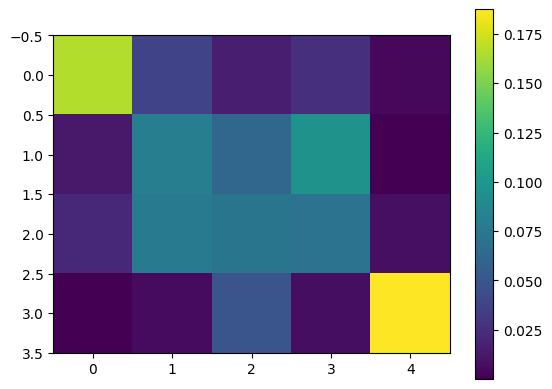

In [14]:
plt.imshow(ot_map.matrix)
plt.colorbar()